# Cloud removal Analisys

In [51]:
import random
from pathlib import Path

import pandas as pd

from utils.plots import (
    plot_monthly_water,
    plot_tif,
    plot_water_over_time,
    plot_water_x_cloud_percent,
    plot_water_x_cloud_percent_filter,
    plot_water_x_cloud_percent_over_time,
    plot_year_x_variable,
)
from utils.water import calculate_water_area



In [52]:
root = Path("../data/02_boa_images/sume")
metadata_path = root / 'metadata' / 'sentinel_6B_BOA_S2_SR_sume.csv'

In [53]:
root.resolve(), metadata_path.resolve()

(WindowsPath('C:/Users/weverton.vitor/Documents/faculdade/pibic/fmask-pipeline/data/02_boa_images/sume'),
 WindowsPath('C:/Users/weverton.vitor/Documents/faculdade/pibic/fmask-pipeline/data/02_boa_images/sume/metadata/sentinel_6B_BOA_S2_SR_sume.csv'))

In [54]:
metadata = pd.read_csv(metadata_path.resolve())

In [55]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 100 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   AOT_RETRIEVAL_ACCURACY                480 non-null    int64  
 1   AOT_RETRIEVAL_METHOD                  254 non-null    object 
 2   BOA_ADD_OFFSET_B1                     251 non-null    float64
 3   BOA_ADD_OFFSET_B10                    251 non-null    float64
 4   BOA_ADD_OFFSET_B11                    251 non-null    float64
 5   BOA_ADD_OFFSET_B12                    251 non-null    float64
 6   BOA_ADD_OFFSET_B2                     251 non-null    float64
 7   BOA_ADD_OFFSET_B3                     251 non-null    float64
 8   BOA_ADD_OFFSET_B4                     251 non-null    float64
 9   BOA_ADD_OFFSET_B5                     251 non-null    float64
 10  BOA_ADD_OFFSET_B6                     251 non-null    float64
 11  BOA_ADD_OFFSET_B7 

In [56]:
metadata = metadata[['PRODUCT_ID', 'image_id', "location_name", 'file_name', 'CLOUDY_PIXEL_PERCENTAGE', 'CLOUD_COVERAGE_ASSESSMENT']]
metadata['water_mask_image_path'] = metadata.apply(lambda x: x['file_name'].replace('02_boa_images', '09_spectral_indice'), axis=1)
metadata['water_mask_image_path'] = metadata.apply(lambda x: "\\".join(x['water_mask_image_path'].split("\\")[: -1])+'\\MNDWI\\'+x['file_name'].split("\\")[-1].replace('.tif', "_MNDWI.tif"), axis=1)
metadata['date'] = metadata.apply(lambda x: Path(x['file_name']).name.split('_')[-1].split('.')[0], axis=1)
metadata['year'] = metadata['date'].apply(lambda date: int(f"{date[:4]}"))
metadata['month'] = metadata['date'].apply(lambda date: int(f"{date[4:6]}"))
metadata['day'] = metadata['date'].apply(lambda date: int(f"{date[6:]}"))

metadata["water_mask_image_path"][0], metadata["water_mask_image_path"][1]

('C:\\Users\\weverton.vitor\\Documents\\faculdade\\pibic\\fmask-pipeline\\data\\09_spectral_indice\\sume\\2018\\MNDWI\\sentinel_6B_BOA_S2_SR_sume_20180106_MNDWI.tif',
 'C:\\Users\\weverton.vitor\\Documents\\faculdade\\pibic\\fmask-pipeline\\data\\09_spectral_indice\\sume\\2018\\MNDWI\\sentinel_6B_BOA_S2_SR_sume_20180531_MNDWI.tif')

In [57]:
metadata["file_name_clean"] = metadata["file_name"].apply(
    lambda x: x.replace("02_boa_images", "04_clean_images").replace(
        ".tif", "_clean.tif"
    )
)

metadata["water_mask_image_path_fmask"] = metadata[
    "water_mask_image_path"
].apply(
    lambda x: x.replace("MNDWI.tif", "clean_MNDWI.tif").replace("sume", "sume_mndwi_fmask", 1)
)

metadata["water_mask_image_path"] = metadata[
    "water_mask_image_path"
].apply(lambda x: x.replace("sume", "sume_mndwi_no_preprocess", 1))


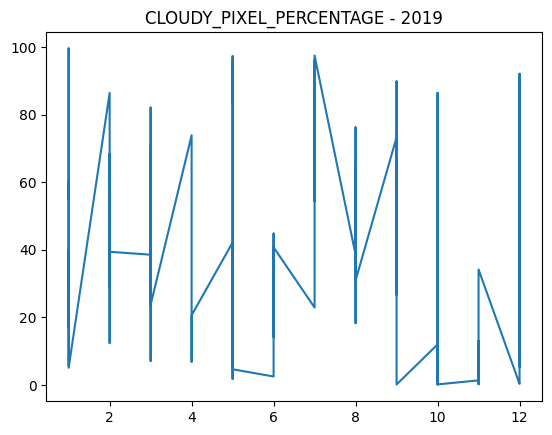

In [58]:
plot_year_x_variable(data=metadata, year=2019)

## Cloud distribution 

<Axes: >

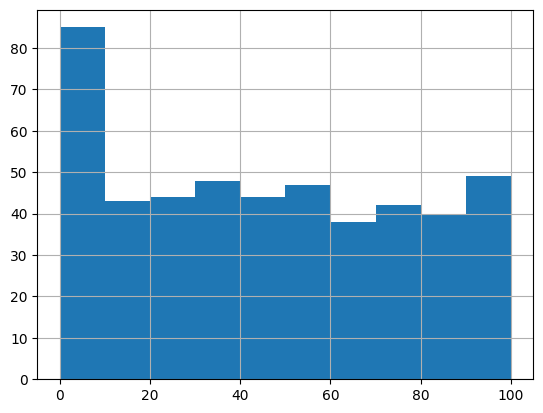

In [59]:
metadata['CLOUDY_PIXEL_PERCENTAGE'].hist()

## Water Area of NDWI Without Cloud  Removal

C:\Users\weverton.vitor\Documents\faculdade\pibic\fmask-pipeline\data\02_boa_images\sume\2023\sentinel_6B_BOA_S2_SR_sume_20230530.tif
C:\Users\weverton.vitor\Documents\faculdade\pibic\fmask-pipeline\data\09_spectral_indice\sume_mndwi_no_preprocess\2023\MNDWI\sentinel_6B_BOA_S2_SR_sume_20230530_MNDWI.tif
Água(m^2): 1150092.5370650294
Água(km^2): 1.1500925370650295


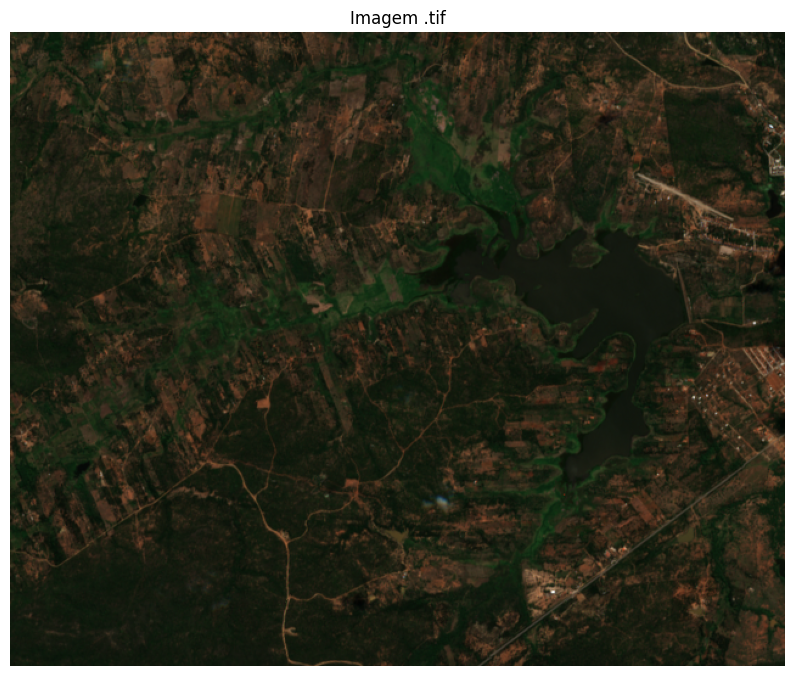

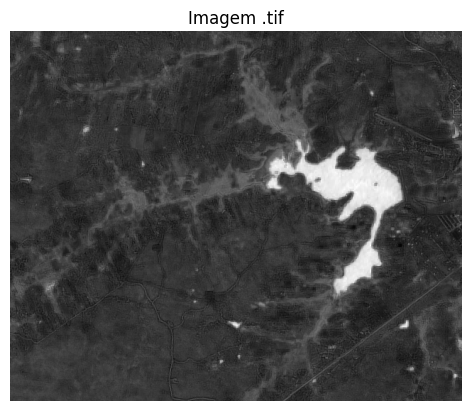

In [60]:
images = metadata['file_name']
images_water_mask = metadata['water_mask_image_path']
rand = random.randint(0, len(images))

m2, km2 = calculate_water_area(images_water_mask[rand], binarization_gt=0.2)
print(images[rand])
print(images_water_mask[rand])
print(f"Água(m^2): {m2}")
print(f"Água(km^2): {km2}")
plot_tif(images[rand], bandas=[4, 3, 2])
plot_tif(images_water_mask[rand], binarization_gt=None)

### Water Area For Many Scenes

In [89]:
m2_areas = []
km2_areas = []
for index, row in metadata.iterrows():
    m2, km2 = calculate_water_area(row['water_mask_image_path'])
    m2_areas.append(m2)
    km2_areas.append(km2)

metadata['m2_area_mndwi'] = pd.Series(m2_areas)
metadata['km2_area_mndwi'] = pd.Series(km2_areas)

In [90]:
metadata[["m2_area_mndwi", "km2_area_mndwi"]]

m2_area_mndwi  km2_area_mndwi
0     2.543595e+06        2.543595
1     2.446290e+07       24.462902
2     1.319741e+07       13.197410
3     8.700529e+05        0.870053
4     8.182593e+05        0.818259
..             ...             ...
475   1.176511e+07       11.765112
476   1.788817e+07       17.888173
477   2.111818e+07       21.118180
478   1.846233e+07       18.462333
479   1.696121e+07       16.961206

[480 rows x 2 columns]

#### Saving Areas to CSV

In [91]:
try:
    areas = pd.read_csv('./data/areas.csv')
    areas["m2_area_mndwi"] = metadata["m2_area_mndwi"]
    areas["km2_area_mndwi"] =metadata["km2_area_mndwi"]
    areas.to_csv('./data/areas.csv', index=False)
except FileNotFoundError:
    metadata[["m2_area_mndwi", "km2_area_mndwi"]].to_csv('./data/areas.csv', index=False)

#### Plots

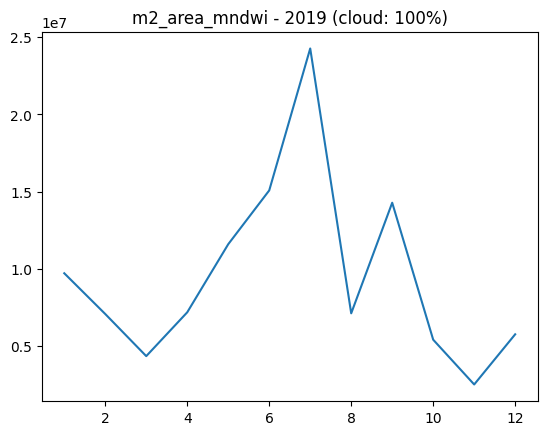

In [64]:
plot_water_x_cloud_percent_filter(data=metadata, year=2019, y_varible="m2_area_mndwi", cloud_percent=100)

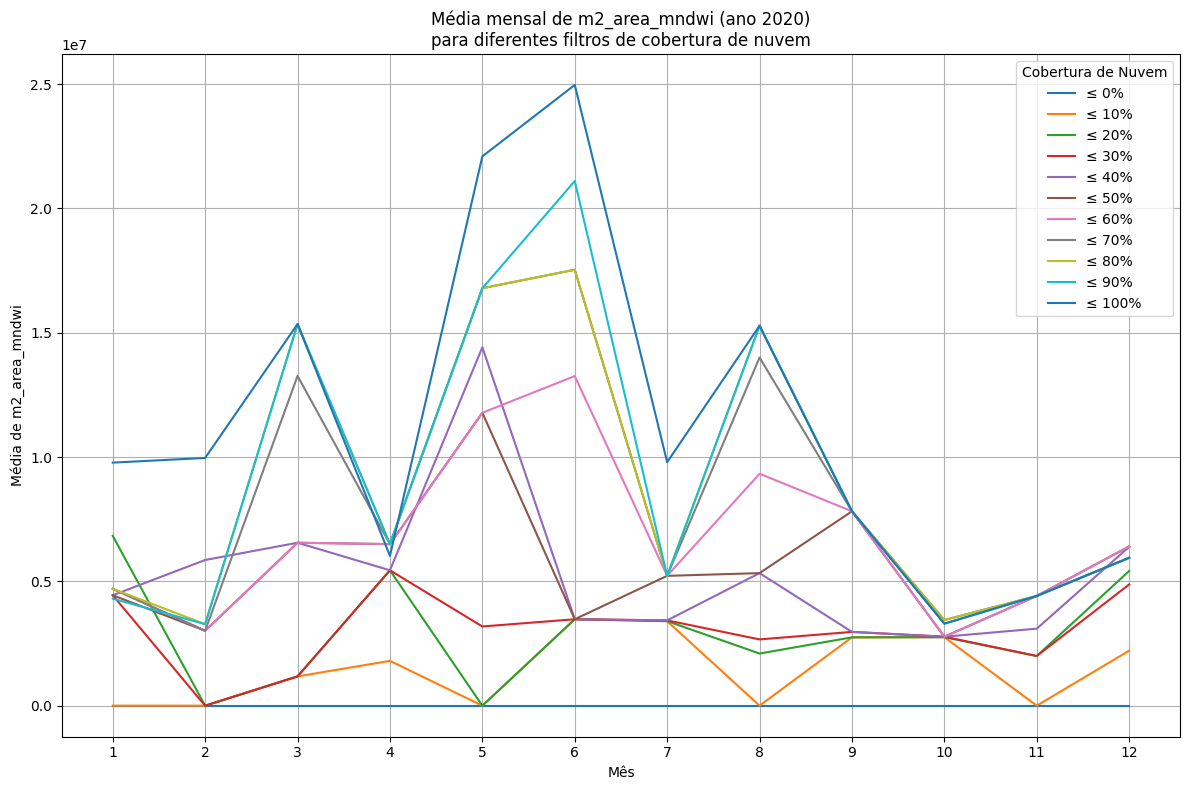

In [65]:
plot_water_x_cloud_percent(metadata, year=2020, y_variable='m2_area_mndwi')


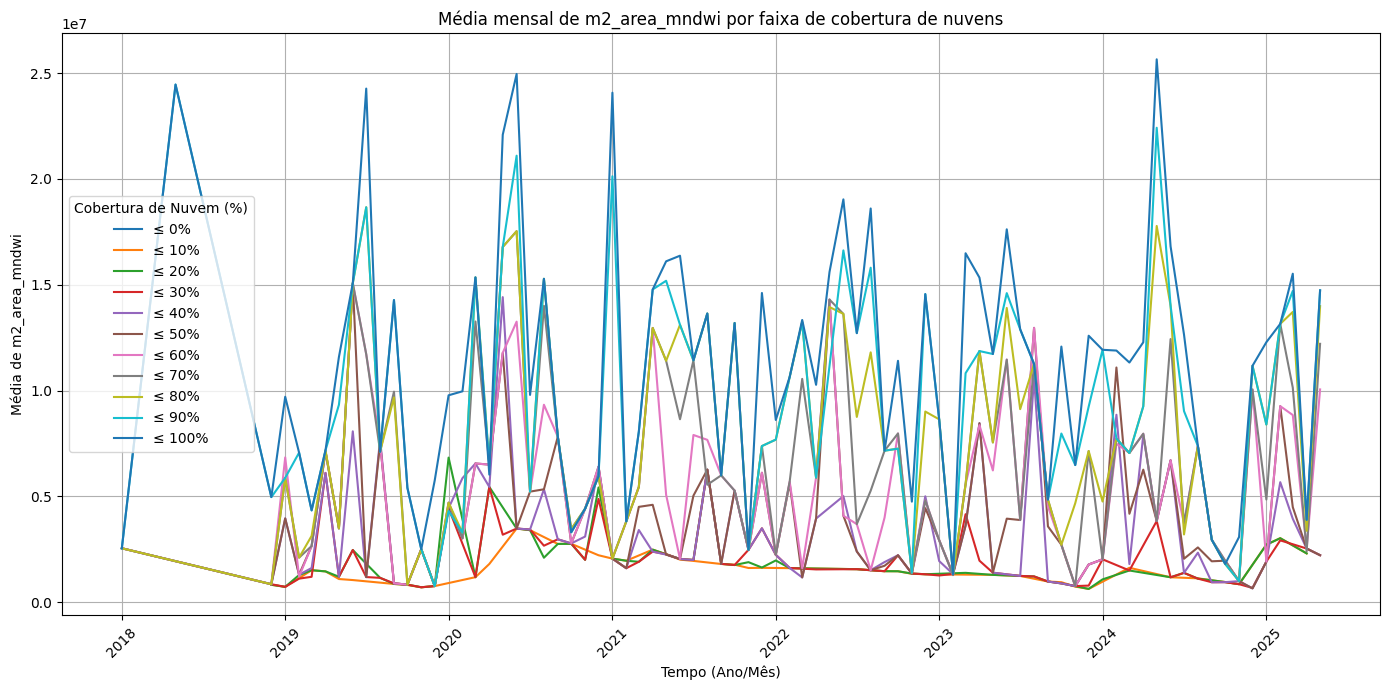

In [66]:
plot_water_x_cloud_percent_over_time(metadata, y_variable='m2_area_mndwi')

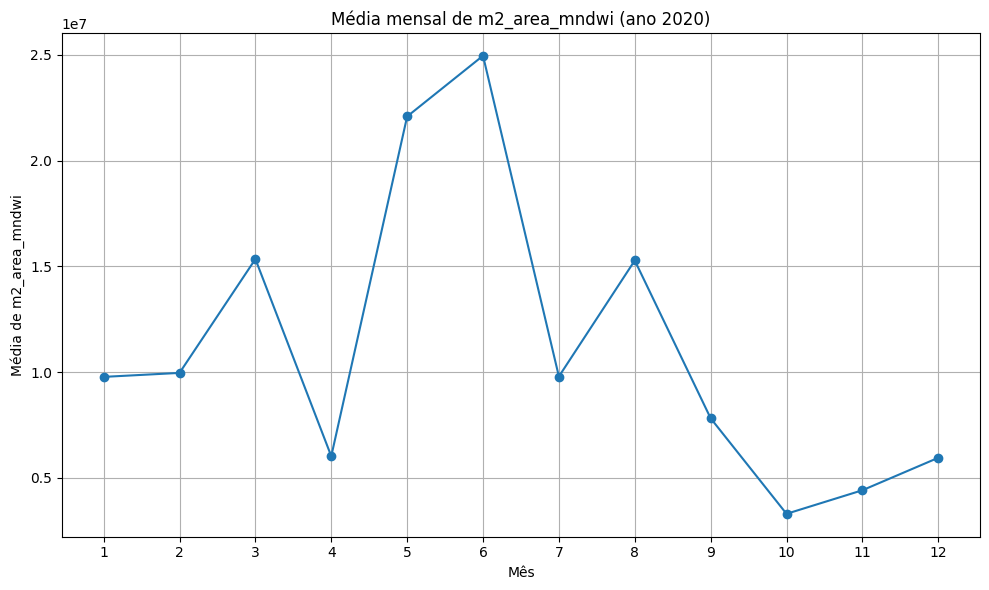

In [67]:
plot_monthly_water(metadata, year=2020, y_variable='m2_area_mndwi')

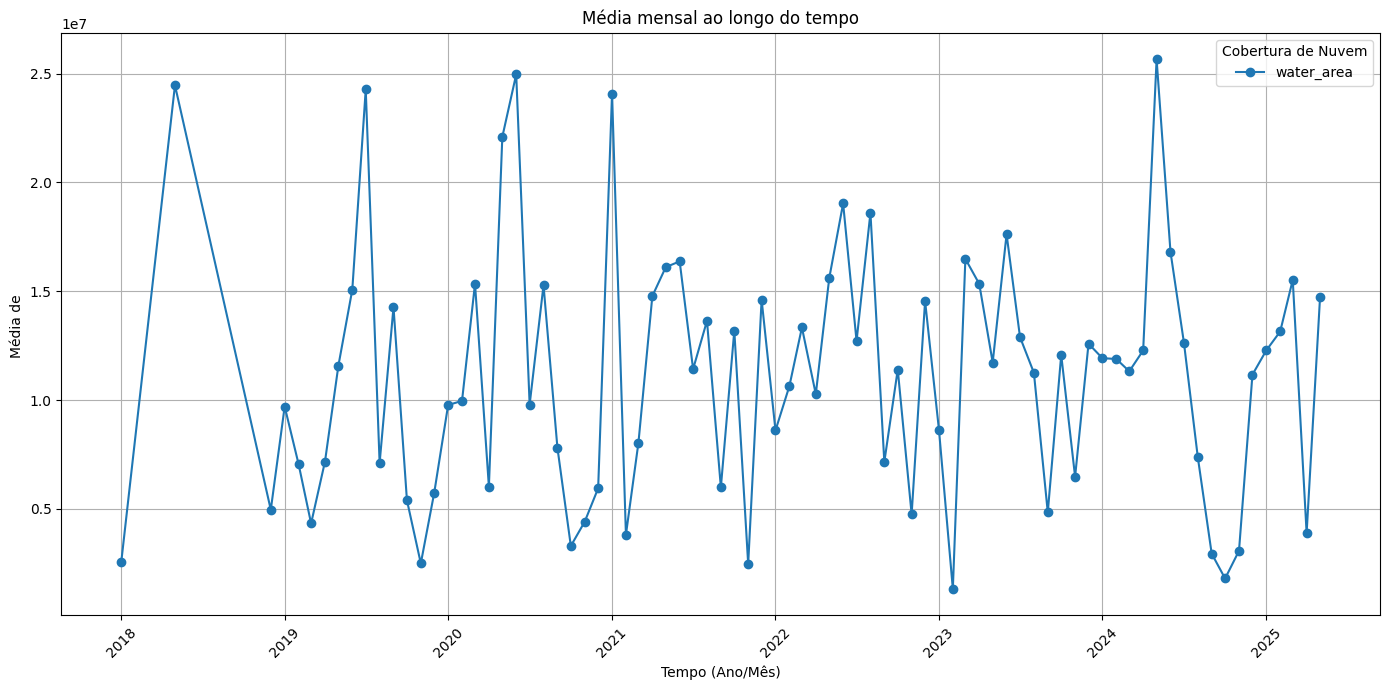

In [68]:
plot_water_over_time(metadata, y_variables=['m2_area_mndwi'])

## Water Area of MNDWI With Cloud Removal

C:\Users\weverton.vitor\Documents\faculdade\pibic\fmask-pipeline\data\04_clean_images\sume\2023\sentinel_6B_BOA_S2_SR_sume_20230530_clean.tif
C:\Users\weverton.vitor\Documents\faculdade\pibic\fmask-pipeline\data\09_spectral_indice\sume_mndwi_fmask\2023\MNDWI\sentinel_6B_BOA_S2_SR_sume_20230530_clean_MNDWI.tif
Água(m^2): 1317486.142631001
Água(km^2): 1.3174861426310012


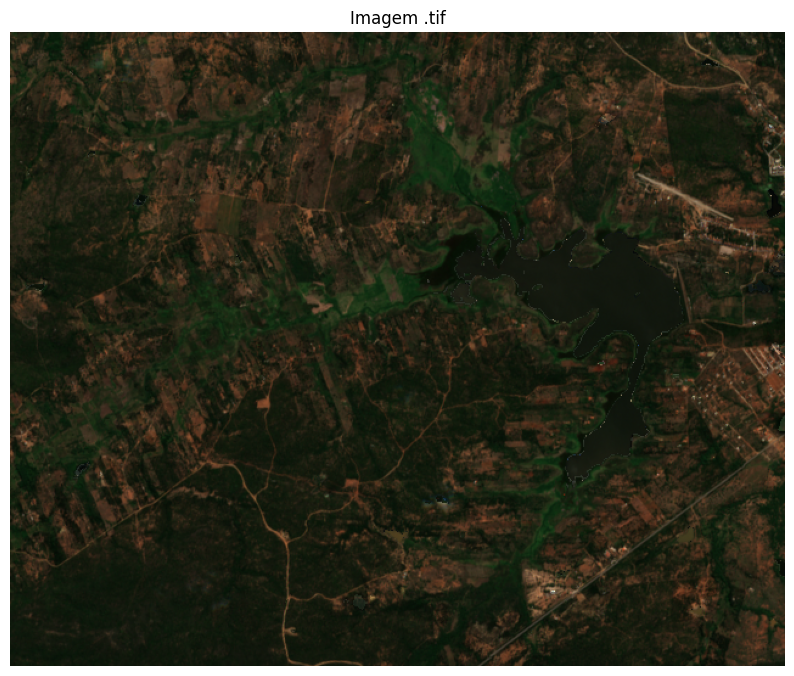

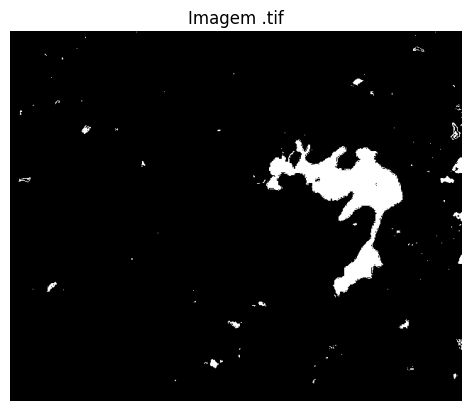

In [69]:
images = metadata['file_name_clean']
images_water_mask = metadata['water_mask_image_path_fmask']
# rand = random.randint(0, len(images))

m2, km2 = calculate_water_area(images_water_mask[rand], binarization_gt=0.2)
print(images[rand])
print(images_water_mask[rand])
print(f"Água(m^2): {m2}")
print(f"Água(km^2): {km2}")
plot_tif(images[rand], bandas=[4, 3, 2])
plot_tif(images_water_mask[rand], binarization_gt=0.2)

### Water Area For Many Scenes

In [70]:
m2_areas = []
km2_areas = []
for index, row in metadata.iterrows():
    try:
        m2, km2 = calculate_water_area(row['water_mask_image_path_fmask'])
        m2_areas.append(m2)
        km2_areas.append(km2)
    except:
        print(f"Error to calculate water area of {row['water_mask_image_path_fmask']}")

metadata['m2_area_fmask_mndwi'] = pd.Series(m2_areas)
metadata['km2_area_fmask_mndwi'] = pd.Series(km2_areas)

Error to calculate water area of C:\Users\weverton.vitor\Documents\faculdade\pibic\fmask-pipeline\data\09_spectral_indice\sume_mndwi_fmask\2018\MNDWI\sentinel_6B_BOA_S2_SR_sume_20180106_clean_MNDWI.tif
Error to calculate water area of C:\Users\weverton.vitor\Documents\faculdade\pibic\fmask-pipeline\data\09_spectral_indice\sume_mndwi_fmask\2018\MNDWI\sentinel_6B_BOA_S2_SR_sume_20180531_clean_MNDWI.tif
Error to calculate water area of C:\Users\weverton.vitor\Documents\faculdade\pibic\fmask-pipeline\data\09_spectral_indice\sume_mndwi_fmask\2018\MNDWI\sentinel_6B_BOA_S2_SR_sume_20181217_clean_MNDWI.tif


In [71]:
metadata[["m2_area_fmask_mndwi", "km2_area_fmask_mndwi"]]

m2_area_fmask_mndwi  km2_area_fmask_mndwi
0           3.270280e+06              3.270280
1           8.834444e+05              0.883444
2           9.224372e+05              0.922437
3           3.269877e+07             32.698765
4           2.564726e+07             25.647261
..                   ...                   ...
475         2.299555e+07             22.995549
476         2.575508e+07             25.755082
477                  NaN                   NaN
478                  NaN                   NaN
479                  NaN                   NaN

[480 rows x 2 columns]

#### Saving Area to CSV

In [92]:
try:
    areas = pd.read_csv('./data/areas.csv')
    areas["m2_area_fmask_mndwi"] = metadata["m2_area_fmask_mndwi"]
    areas["km2_area_fmask_mndwi"] =metadata["km2_area_fmask_mndwi"]
    areas.to_csv('./data/areas.csv', index=False)
except FileNotFoundError:
    metadata[["m2_area_fmask_mndwi", "km2_area_fmask_mndwi"]].to_csv('./data/areas.csv', index=False)

#### Plots

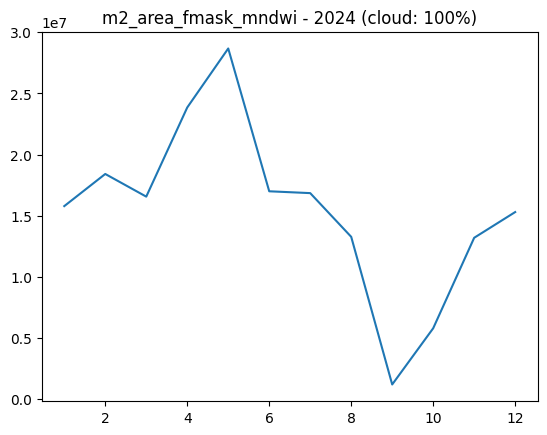

In [72]:
plot_water_x_cloud_percent_filter(data=metadata, year=2024, y_varible="m2_area_fmask_mndwi", cloud_percent=100)

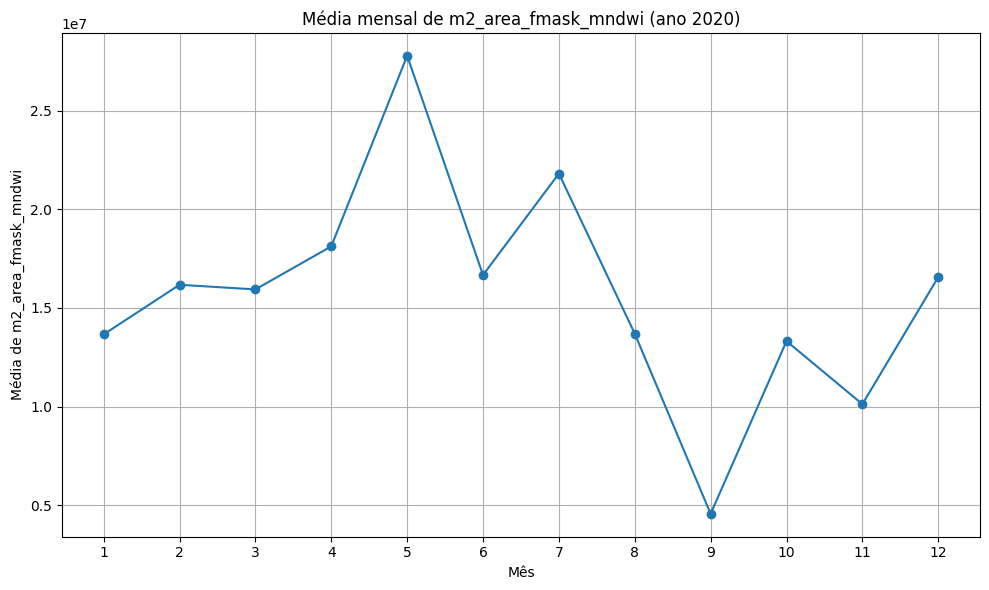

In [73]:
plot_monthly_water(metadata, year=2020, y_variable='m2_area_fmask_mndwi')

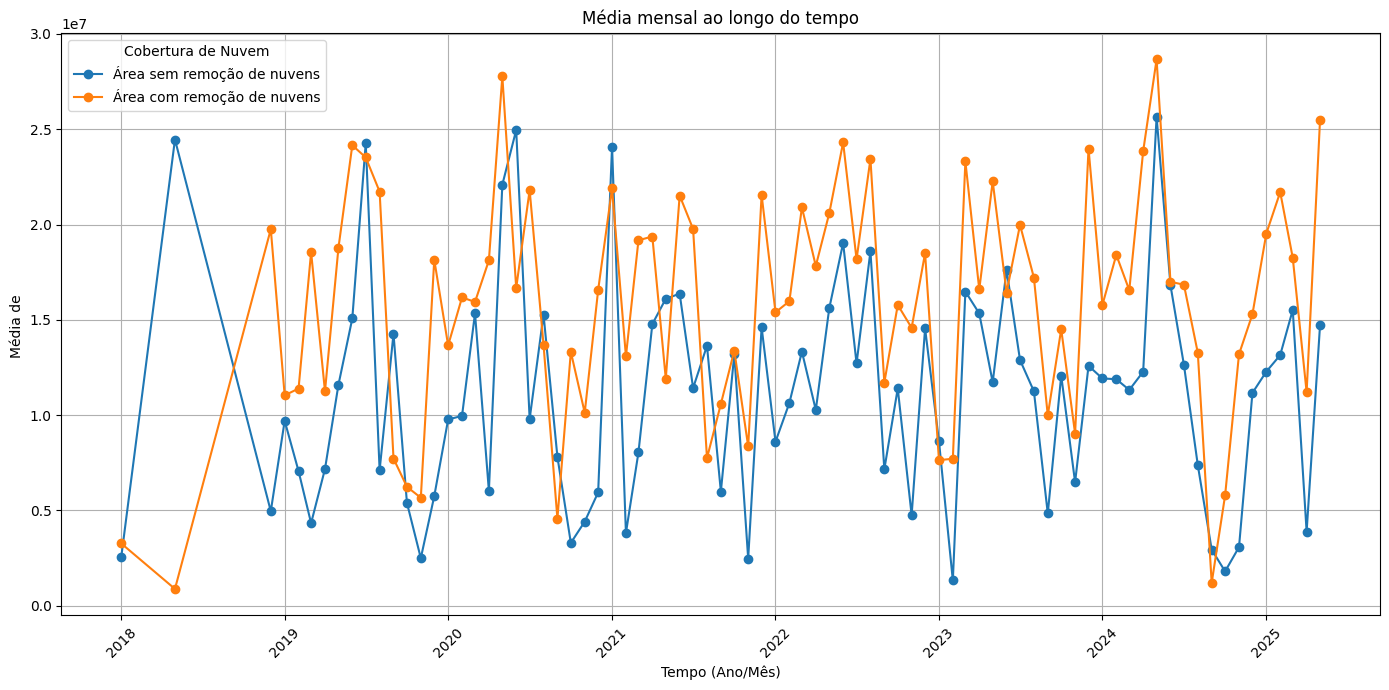

In [74]:
plot_water_over_time(metadata, y_variables=['m2_area_mndwi', 'm2_area_fmask_mndwi'], labels=['Área sem remoção de nuvens', 'Área com remoção de nuvens'])

In [75]:
import rasterio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def plot_band_stats_over_time_from_paths(
    df: pd.DataFrame,
    image_path_column: str,
    year_column: str,
    month_column: str,
    stat: str = 'mean'  # 'mean' ou 'std'
):
    """
    Plota a média ou desvio padrão de cada banda espectral ao longo do tempo, com cores fixas por banda.

    Parâmetros:
        df (pd.DataFrame): DataFrame com colunas de caminho da imagem, ano e mês.
        image_path_column (str): Nome da coluna com os caminhos das imagens.
        year_column (str): Nome da coluna com o ano.
        month_column (str): Nome da coluna com o mês.
        stat (str): 'mean' para média, 'std' para desvio padrão.
    """
    # Garante a coluna de data
    data = df.copy()
    data['date'] = pd.to_datetime(data[[year_column, month_column]].assign(day=1))

    registros = []

    for _, row in data.iterrows():
        image_path = row[image_path_column]
        date = row['date']

        try:
            with rasterio.open(image_path) as src:
                bands = []
                for i in range(1, src.count + 1):
                    band = src.read(i).astype(float)
                    band = band[~np.isnan(band)]

                    if band.size == 0:
                        bands.append(np.nan)
                        continue

                    if stat == 'mean':
                        bands.append(np.mean(band))
                    elif stat == 'std':
                        bands.append(np.std(band))
                    else:
                        raise ValueError("O parâmetro 'stat' deve ser 'mean' ou 'std'")
        except Exception as e:
            print(f"Erro ao processar {image_path}: {e}")
            continue

        registros.append((date, bands))

    # DataFrame final
    df_result = pd.DataFrame([
        {'date': r[0], **{f'Band {i+1}': r[1][i] for i in range(len(r[1]))}}
        for r in registros
    ])
    df_result = df_result.sort_values('date')

    # Cores fixas por banda (tab10 = até 10 cores distintas)
    num_bands = len([col for col in df_result.columns if col != 'date'])
    color_map = cm.get_cmap('tab10', num_bands)
    band_colors = {f'Band {i+1}': color_map(i) for i in range(num_bands)}

    # Plot
    plt.figure(figsize=(14, 6))
    for band, color in band_colors.items():
        if band in df_result.columns:
            plt.plot(df_result['date'], df_result[band], label=band, color=color)

    plt.title(f"{'Média' if stat == 'mean' else 'Desvio Padrão'} das Bandas ao Longo do Tempo")
    plt.xlabel("Data")
    plt.ylabel("Valor")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


C:\Users\weverton.vitor\AppData\Local\Temp\ipykernel_38012\591096204.py:66: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('tab10', num_bands)


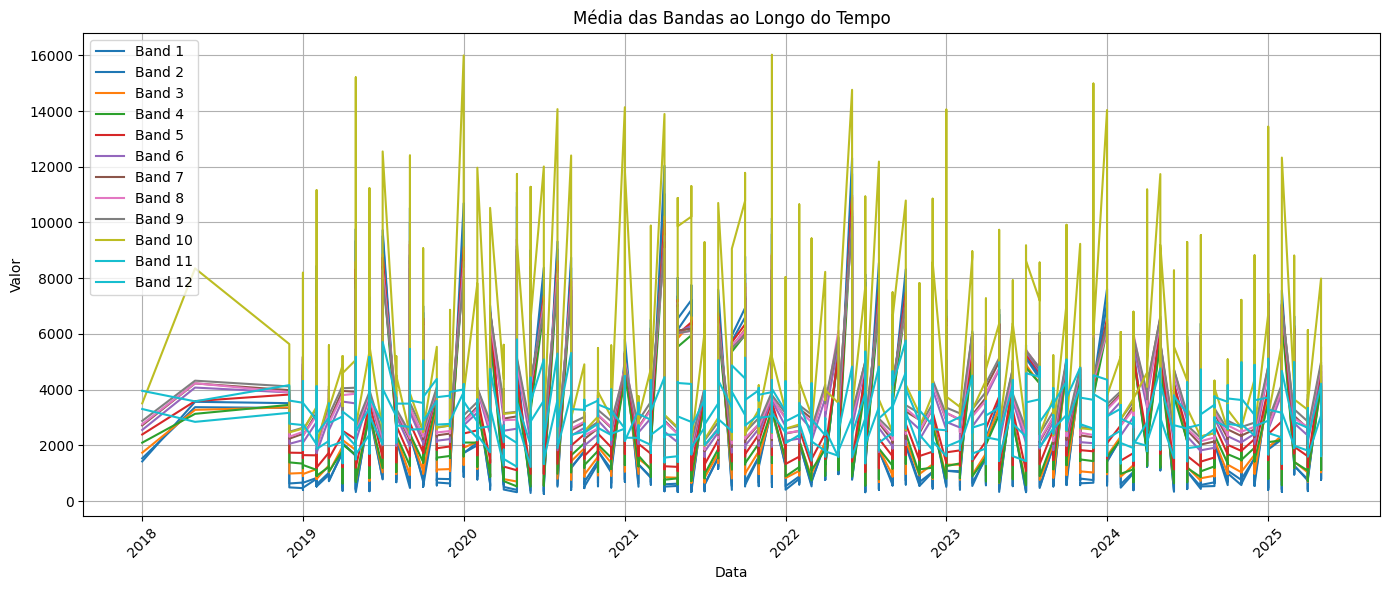

In [76]:
plot_band_stats_over_time_from_paths(
    df=metadata,
    image_path_column='file_name',
    year_column='year',
    month_column='month',
    stat='mean')  # ou 'std'

Erro ao processar C:\Users\weverton.vitor\Documents\faculdade\pibic\fmask-pipeline\data\04_clean_images\sume\2018\sentinel_6B_BOA_S2_SR_sume_20180106_clean.tif: C:\Users\weverton.vitor\Documents\faculdade\pibic\fmask-pipeline\data\04_clean_images\sume\2018\sentinel_6B_BOA_S2_SR_sume_20180106_clean.tif: No such file or directory
Erro ao processar C:\Users\weverton.vitor\Documents\faculdade\pibic\fmask-pipeline\data\04_clean_images\sume\2018\sentinel_6B_BOA_S2_SR_sume_20180531_clean.tif: C:\Users\weverton.vitor\Documents\faculdade\pibic\fmask-pipeline\data\04_clean_images\sume\2018\sentinel_6B_BOA_S2_SR_sume_20180531_clean.tif: No such file or directory
Erro ao processar C:\Users\weverton.vitor\Documents\faculdade\pibic\fmask-pipeline\data\04_clean_images\sume\2018\sentinel_6B_BOA_S2_SR_sume_20181217_clean.tif: C:\Users\weverton.vitor\Documents\faculdade\pibic\fmask-pipeline\data\04_clean_images\sume\2018\sentinel_6B_BOA_S2_SR_sume_20181217_clean.tif: No such file or directory


C:\Users\weverton.vitor\AppData\Local\Temp\ipykernel_38012\591096204.py:66: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('tab10', num_bands)


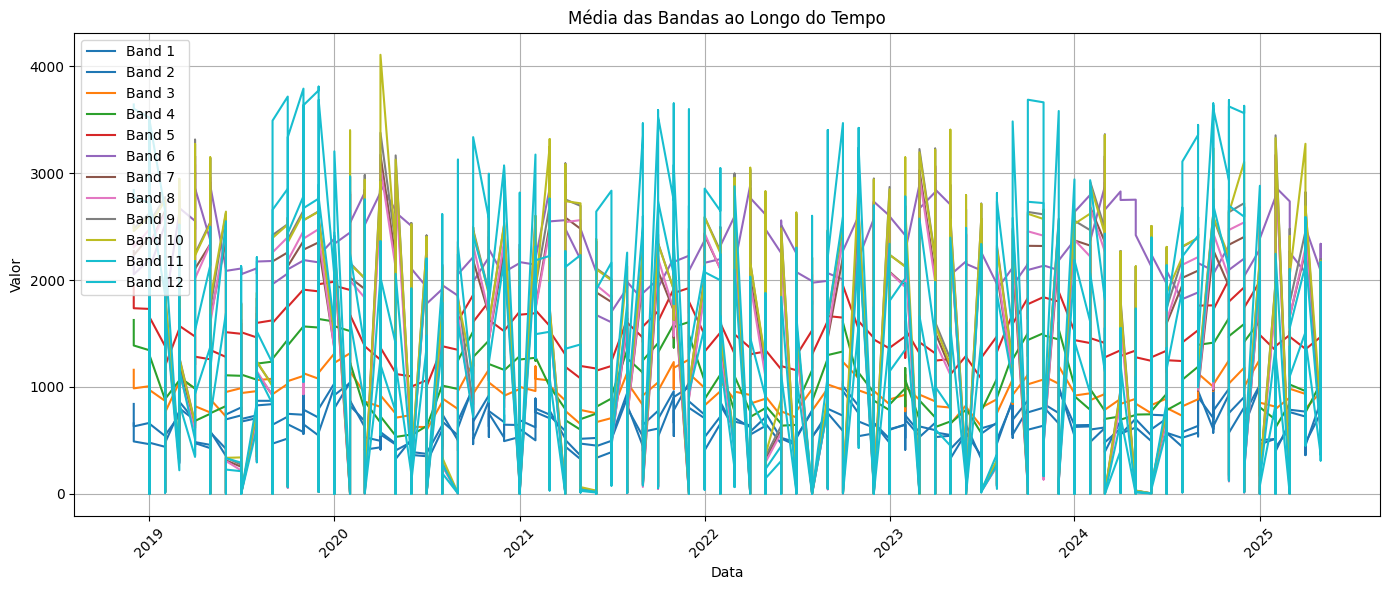

In [77]:
plot_band_stats_over_time_from_paths(
    df=metadata,
    image_path_column='file_name_clean',
    year_column='year',
    month_column='month',
    stat='mean')  # ou 'std'

## RGB Reflectance

In [78]:
import rasterio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def plot_selected_band_stats_over_time(
    df: pd.DataFrame,
    image_path_column: str,
    year_column: str,
    month_column: str,
    stat: str = 'mean',          # 'mean' ou 'std'
    bands_to_use: list = None,    # ex: [0, 2, 7] para Bandas 1, 3 e 8
    year=""
):
    """
    Plota a média ou desvio padrão de bandas selecionadas ao longo do tempo, com cores fixas por banda.

    Parâmetros:
        df (pd.DataFrame): DataFrame com colunas de caminho da imagem, ano e mês.
        image_path_column (str): Nome da coluna com os caminhos das imagens.
        year_column (str): Nome da coluna com o ano.
        month_column (str): Nome da coluna com o mês.
        stat (str): Estatística a calcular: 'mean' ou 'std'.
        bands_to_use (list): Lista de índices das bandas (começando em 0).
    """
    # Verificação básica
    if bands_to_use is None or len(bands_to_use) == 0:
        raise ValueError("Você deve fornecer uma lista com os índices das bandas a usar (ex: [0, 2, 7])")


    data = df.copy()

    if year:
        # Filtra os dados para o ano especificado
        data = data.loc[data[year_column] == year]

    # Cria a coluna de data
    data['date'] = pd.to_datetime(data[[year_column, month_column]].assign(day=1))

    registros = []

    for _, row in data.iterrows():
        image_path = row[image_path_column]
        date = row['date']

        try:
            with rasterio.open(image_path) as src:
                bands = []
                for b in bands_to_use:
                    band_index = b + 1  # rasterio é 1-based
                    if band_index > src.count:
                        bands.append(np.nan)
                        continue

                    band = src.read(band_index).astype(float)
                    band = band[~np.isnan(band)]

                    if band.size == 0:
                        bands.append(np.nan)
                        continue

                    if stat == 'mean':
                        bands.append(np.mean(band))
                    elif stat == 'std':
                        bands.append(np.std(band))
                    else:
                        raise ValueError("O parâmetro 'stat' deve ser 'mean' ou 'std'")
        except Exception as e:
            print(f"Erro ao processar {image_path}: {e}")
            continue

        registros.append((date, bands))

    # DataFrame final
    df_result = pd.DataFrame([
        {'date': r[0], **{f'Band {bands_to_use[i]+1}': r[1][i] for i in range(len(r[1]))}}
        for r in registros
    ])

    # print(df_result.head())
    print(list(df_result.columns))
    df_result = df_result.sort_values('date')

    # Cores fixas com colormap tab10/Set1/etc.
    color_map = cm.get_cmap('tab10', len(bands_to_use))
    band_labels = [f'Band {i+1}' for i in bands_to_use]
    band_colors = {label: color_map(i) for i, label in enumerate(band_labels)}

    # Plot
    plt.figure(figsize=(14, 6))
    for band_label in band_labels:
        if band_label in df_result.columns:
            plt.plot(df_result['date'], df_result[band_label], label=band_label, color=band_colors[band_label])

    plt.title(f"{'Média' if stat == 'mean' else 'Desvio Padrão'} de Bandas Selecionadas ao Longo do Tempo")
    plt.xlabel("Data")
    plt.ylabel("Valor")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


### One Year

['date', 'Band 4', 'Band 3', 'Band 2']


C:\Users\weverton.vitor\AppData\Local\Temp\ipykernel_38012\2321338767.py:86: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('tab10', len(bands_to_use))


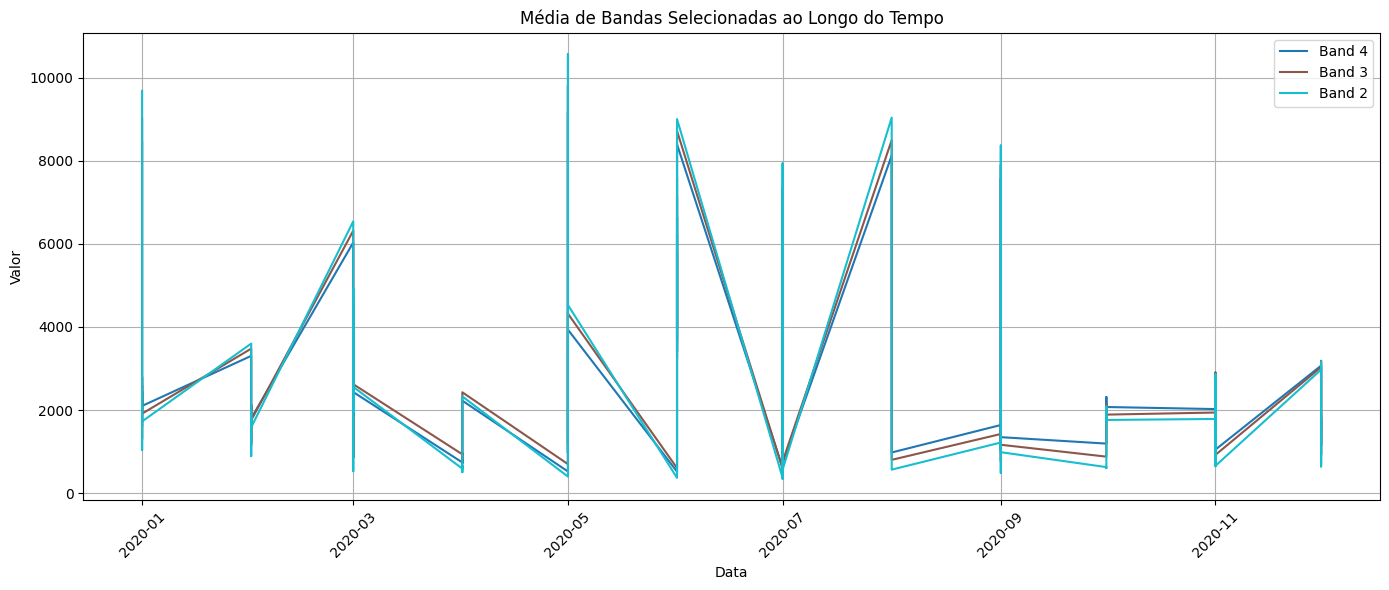

In [79]:
plot_selected_band_stats_over_time(
    df=metadata,
    image_path_column='file_name',
    year_column='year',
    month_column='month',
    stat='mean',
    bands_to_use=[3, 2, 1],  # Bandas 4, 3 e 2
    year=2020
)


['date', 'Band 4', 'Band 3', 'Band 2']


C:\Users\weverton.vitor\AppData\Local\Temp\ipykernel_38012\2321338767.py:86: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('tab10', len(bands_to_use))


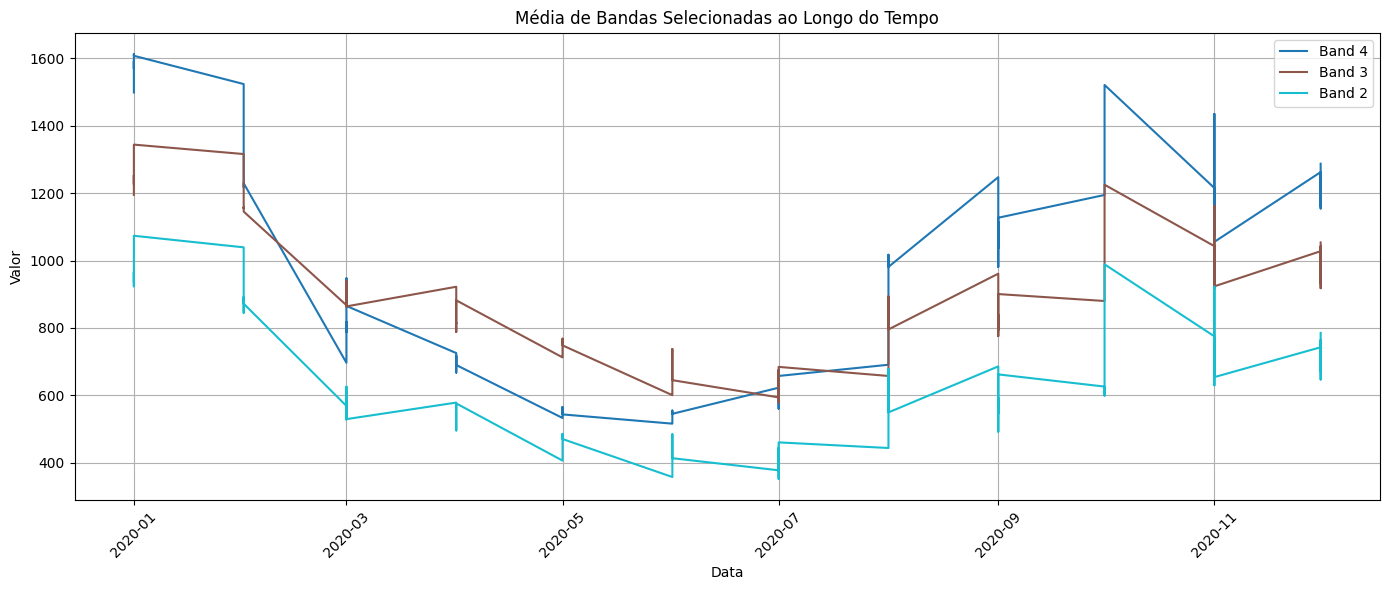

In [80]:
plot_selected_band_stats_over_time(
    df=metadata,
    image_path_column='file_name_clean',
    year_column='year',
    month_column='month',
    stat='mean',
    bands_to_use=[3, 2, 1],  # Bandas 4, 3 e 2
    year=2020
)


### All Years

['date', 'Band 4', 'Band 3', 'Band 2']


C:\Users\weverton.vitor\AppData\Local\Temp\ipykernel_38012\2321338767.py:86: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('tab10', len(bands_to_use))


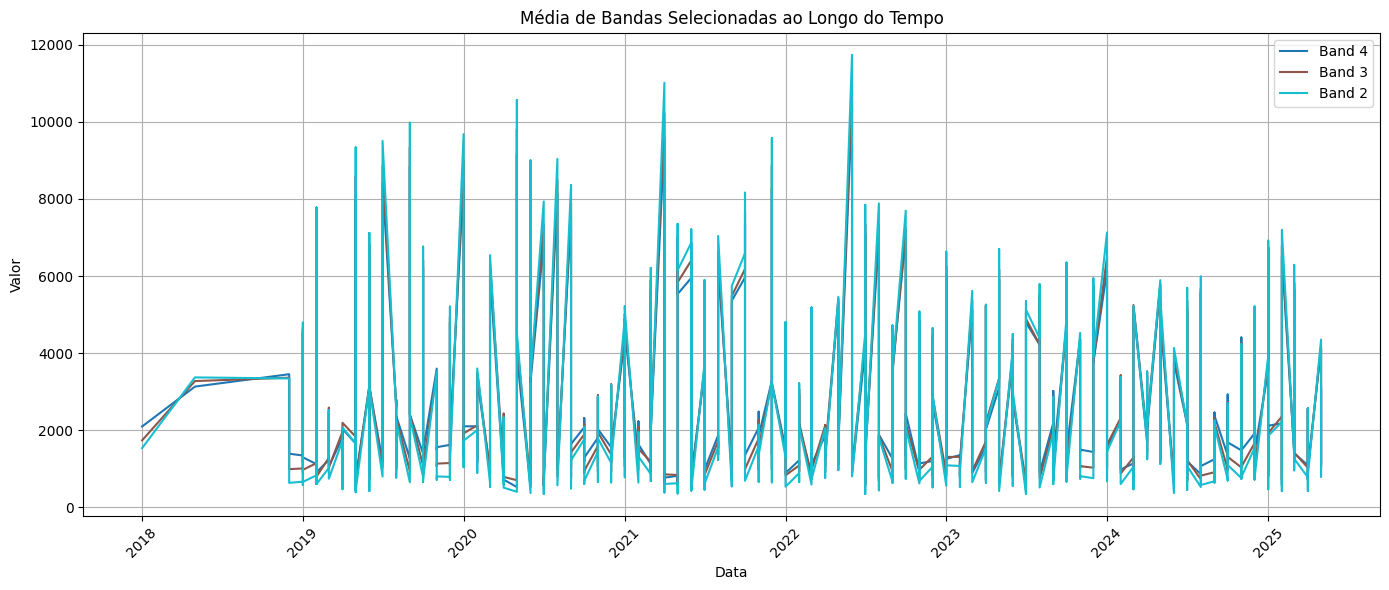

In [81]:
plot_selected_band_stats_over_time(
    df=metadata,
    image_path_column='file_name',
    year_column='year',
    month_column='month',
    stat='mean',
    bands_to_use=[3, 2, 1]  # Bandas 4, 3 e 2
)


Erro ao processar C:\Users\weverton.vitor\Documents\faculdade\pibic\fmask-pipeline\data\04_clean_images\sume\2018\sentinel_6B_BOA_S2_SR_sume_20180106_clean.tif: C:\Users\weverton.vitor\Documents\faculdade\pibic\fmask-pipeline\data\04_clean_images\sume\2018\sentinel_6B_BOA_S2_SR_sume_20180106_clean.tif: No such file or directory
Erro ao processar C:\Users\weverton.vitor\Documents\faculdade\pibic\fmask-pipeline\data\04_clean_images\sume\2018\sentinel_6B_BOA_S2_SR_sume_20180531_clean.tif: C:\Users\weverton.vitor\Documents\faculdade\pibic\fmask-pipeline\data\04_clean_images\sume\2018\sentinel_6B_BOA_S2_SR_sume_20180531_clean.tif: No such file or directory
Erro ao processar C:\Users\weverton.vitor\Documents\faculdade\pibic\fmask-pipeline\data\04_clean_images\sume\2018\sentinel_6B_BOA_S2_SR_sume_20181217_clean.tif: C:\Users\weverton.vitor\Documents\faculdade\pibic\fmask-pipeline\data\04_clean_images\sume\2018\sentinel_6B_BOA_S2_SR_sume_20181217_clean.tif: No such file or directory
['date', '

C:\Users\weverton.vitor\AppData\Local\Temp\ipykernel_38012\2321338767.py:86: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('tab10', len(bands_to_use))


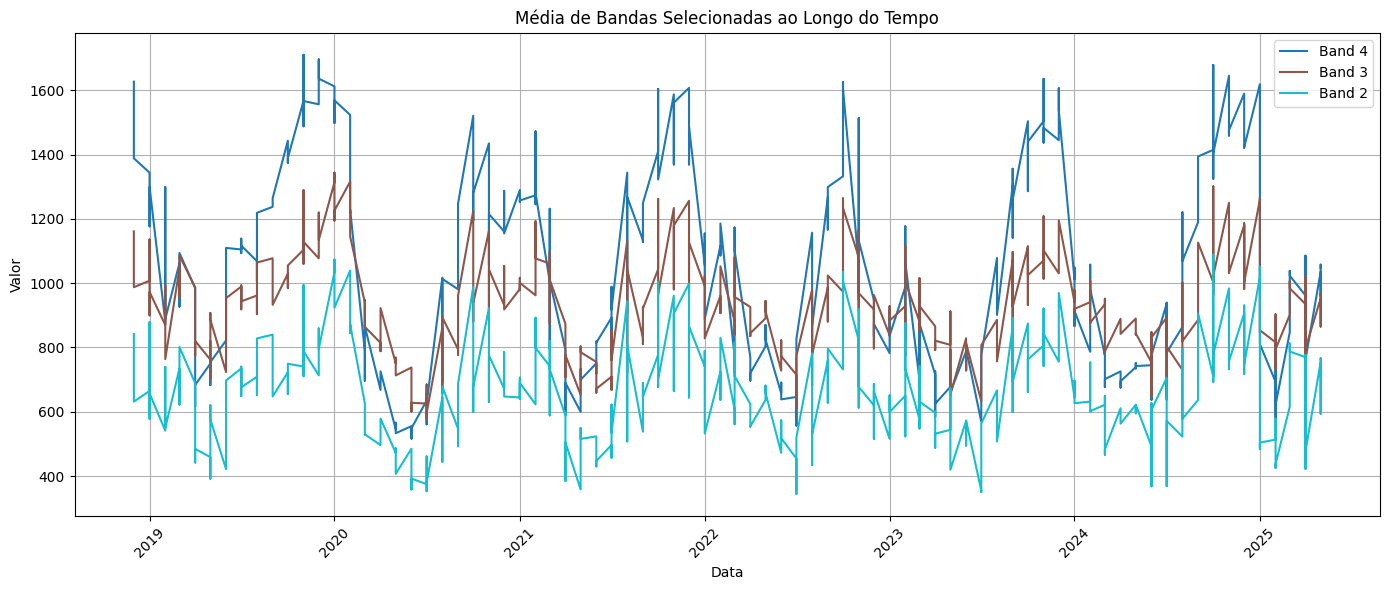

In [82]:
plot_selected_band_stats_over_time(
    df=metadata,
    image_path_column='file_name_clean',
    year_column='year',
    month_column='month',
    stat='mean',
    bands_to_use=[3, 2, 1]  # Bandas 4, 3 e 2
)


## NIR refletance

### One Year

['date', 'Band 8']


C:\Users\weverton.vitor\AppData\Local\Temp\ipykernel_38012\2321338767.py:86: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('tab10', len(bands_to_use))


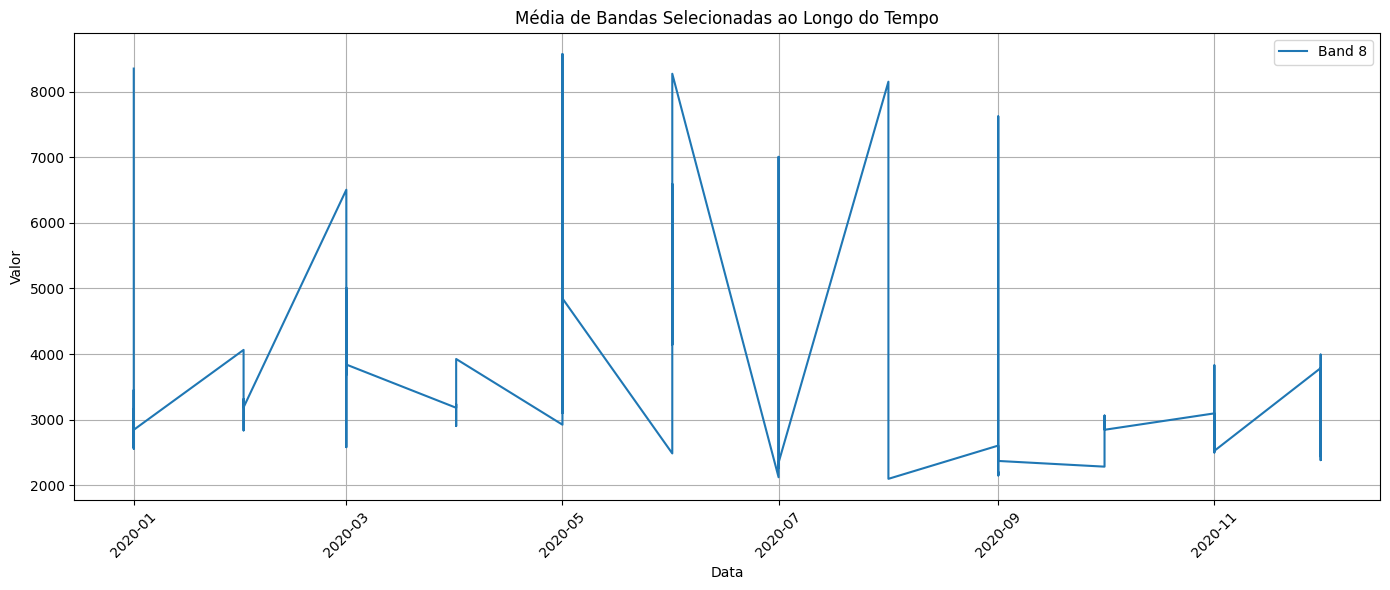

In [83]:
plot_selected_band_stats_over_time(
    df=metadata,
    image_path_column='file_name',
    year_column='year',
    month_column='month',
    stat='mean',
    bands_to_use=[7],  # Bandas 8
    year=2020
)


['date', 'Band 8']


C:\Users\weverton.vitor\AppData\Local\Temp\ipykernel_38012\2321338767.py:86: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('tab10', len(bands_to_use))


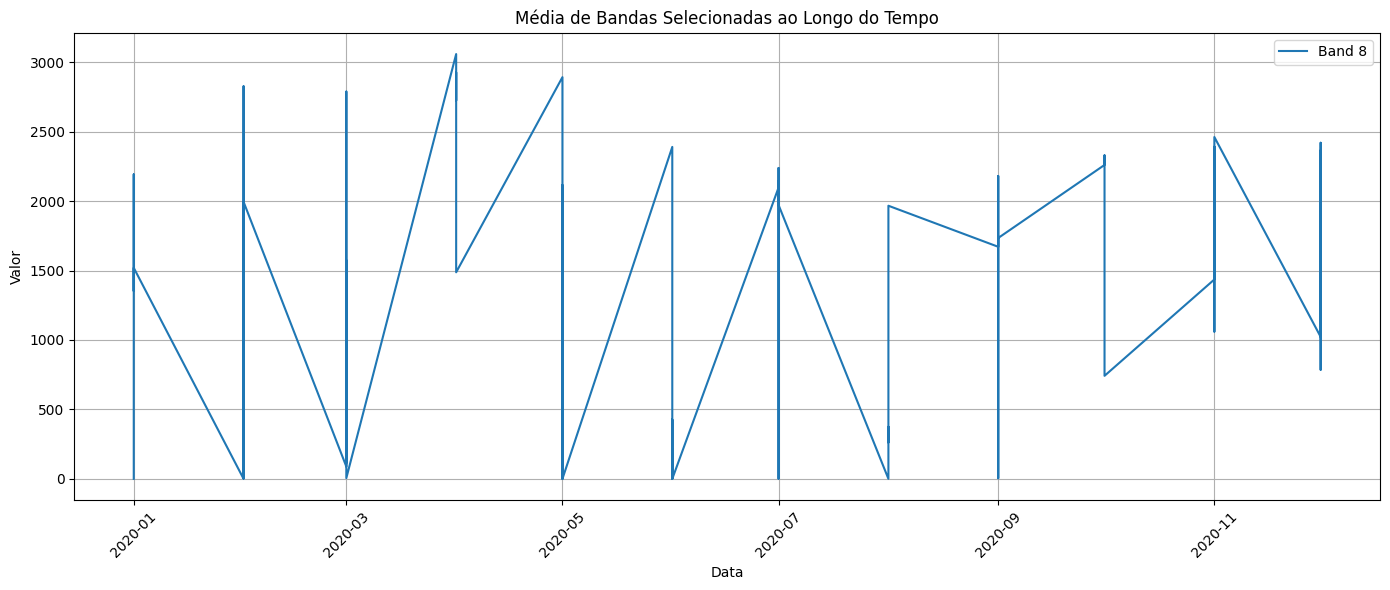

In [84]:
plot_selected_band_stats_over_time(
    df=metadata,
    image_path_column='file_name_clean',
    year_column='year',
    month_column='month',
    stat='mean',
    bands_to_use=[7],  # Bandas 8
    year=2020
)


### All Years

['date', 'Band 8']


C:\Users\weverton.vitor\AppData\Local\Temp\ipykernel_38012\2321338767.py:86: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('tab10', len(bands_to_use))


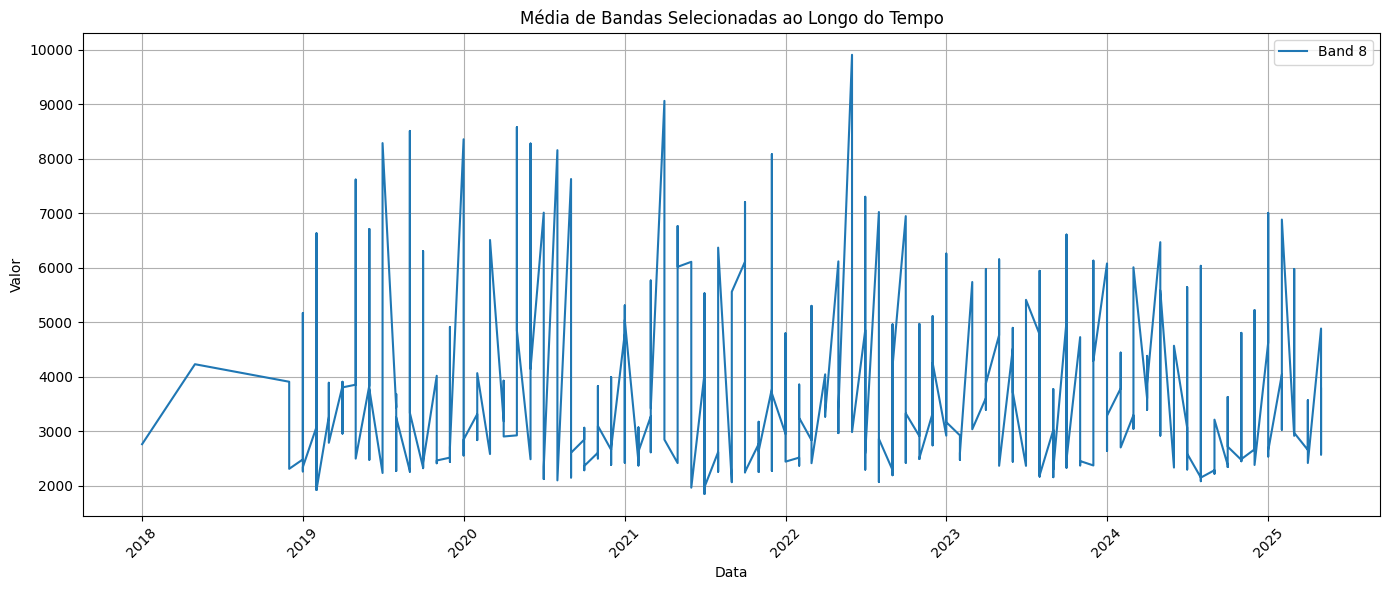

In [85]:
plot_selected_band_stats_over_time(
    df=metadata,
    image_path_column='file_name',
    year_column='year',
    month_column='month',
    stat='mean',
    bands_to_use=[7]  # Bandas 8
)


Erro ao processar C:\Users\weverton.vitor\Documents\faculdade\pibic\fmask-pipeline\data\04_clean_images\sume\2018\sentinel_6B_BOA_S2_SR_sume_20180106_clean.tif: C:\Users\weverton.vitor\Documents\faculdade\pibic\fmask-pipeline\data\04_clean_images\sume\2018\sentinel_6B_BOA_S2_SR_sume_20180106_clean.tif: No such file or directory
Erro ao processar C:\Users\weverton.vitor\Documents\faculdade\pibic\fmask-pipeline\data\04_clean_images\sume\2018\sentinel_6B_BOA_S2_SR_sume_20180531_clean.tif: C:\Users\weverton.vitor\Documents\faculdade\pibic\fmask-pipeline\data\04_clean_images\sume\2018\sentinel_6B_BOA_S2_SR_sume_20180531_clean.tif: No such file or directory
Erro ao processar C:\Users\weverton.vitor\Documents\faculdade\pibic\fmask-pipeline\data\04_clean_images\sume\2018\sentinel_6B_BOA_S2_SR_sume_20181217_clean.tif: C:\Users\weverton.vitor\Documents\faculdade\pibic\fmask-pipeline\data\04_clean_images\sume\2018\sentinel_6B_BOA_S2_SR_sume_20181217_clean.tif: No such file or directory
['date', '

C:\Users\weverton.vitor\AppData\Local\Temp\ipykernel_38012\2321338767.py:86: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('tab10', len(bands_to_use))


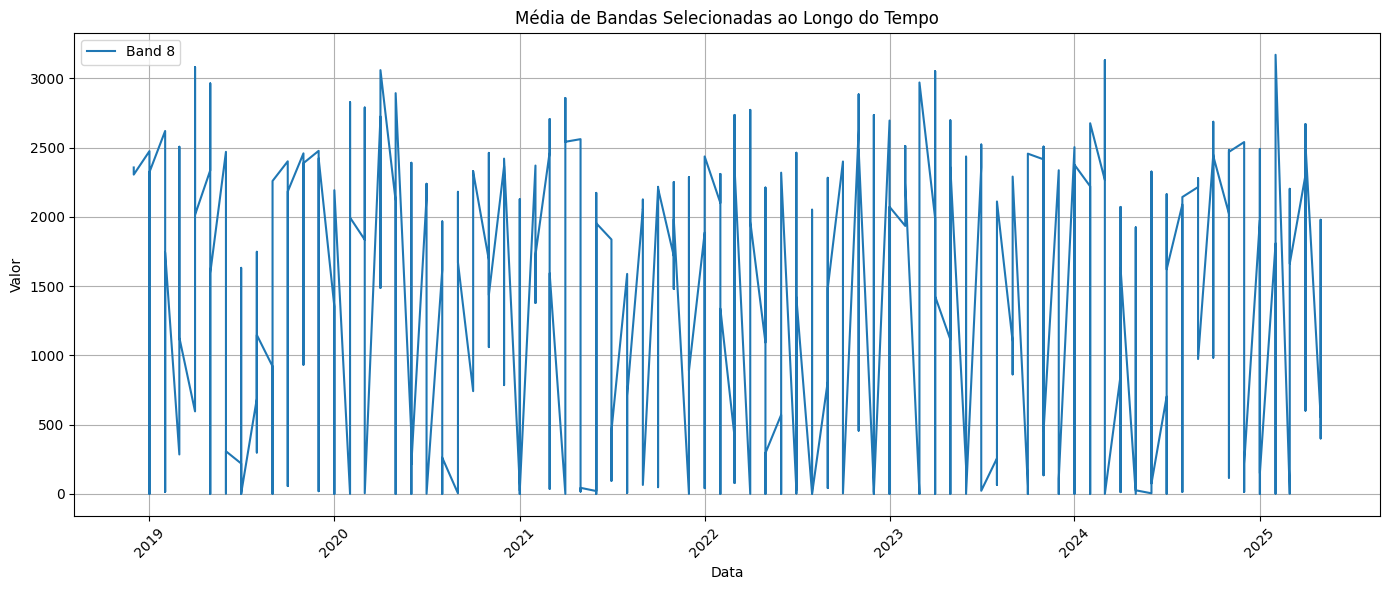

In [86]:
plot_selected_band_stats_over_time(
    df=metadata,
    image_path_column='file_name_clean',
    year_column='year',
    month_column='month',
    stat='mean',
    bands_to_use=[7]  # Bandas 8
)


## Compare